# Aggregate the snow reanalyses HMASR to about 100km (only seasonal snow)

- HMASR: [High Mountain Asia UCLA Daily Snow Reanalysis, Version 1](https://nsidc.org/data/HMA_SR_D)

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=4, threads_per_worker=3, memory_limit='6GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:33993 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 24.00 GB


In [27]:
client.close()

## Create folders

In [4]:
# Create folders
WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
path_out = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_100km/'

!mkdir {path_out}
for WY in WY_list:
    print(WY)
    !mkdir {path_out}{WY}

WY1999_00
WY2000_01
WY2001_02
WY2002_03
WY2003_04
WY2004_05
WY2005_06
WY2006_07
WY2007_08
WY2008_09
WY2009_10
WY2010_11
WY2011_12
WY2012_13
WY2013_14
WY2014_15
WY2015_16
WY2016_17


- FORCING_POST -> PPT_Post
- SD_POST -> SD_Post
- SWE_SCA_POST -> SWE_Post, SCA_Post

## Aggregate data in parallel
There are different option with `dask`. I didn't succeed to make it work with `xr.open_mfdataset` as there are too many files and there is a memory crash. So I finally used the `delayed` option from dask, in order to parallelize a loop.

Here are the different ressources:
- http://xarray.pydata.org/en/stable/user-guide/dask.html
- https://ncar.github.io/xdev/posts/writing-multiple-netcdf-files-in-parallel-with-xarray-and-dask/ (I use this on for writting in parallel)
- https://tutorial.dask.org/01_dask.delayed.html (I used this example for delayed)

The delayed from dask is a bit tricky and we can't use all functions.

The goal here is just to coarsen grids. Then I will put all the files together in a single file for efficiency.

In [7]:
from os import listdir

WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
ds_name_list = ['FORCING_POST', 'SD_POST', 'SWE_SCA_POST']
# ds_name_list = ['SWE_SCA_POST']

for WY in WY_list:
    print(WY)
    path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/'+WY+'/'
    path_out = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_100km/'+WY+'/'
    
    for ds_name in ds_name_list:
        print(ds_name)
        list_files = [f for f in listdir(path) if ds_name in f]
        
        ds_100km = []
        for file in list_files:
            ds = delayed(xr.open_dataset)(path+file)
            mask = delayed(xr.open_dataset)(path+file.replace(ds_name, 'MASK'))
            
            if ds_name in ['FORCING_POST']:
                ds_100km.append(ds.where(mask.Non_seasonal_snow_mask == 0).coarsen(Latitude=225, Longitude=225).mean())
            else:
                # Select only the mean (Stats=0)
                ds_100km.append(ds.isel(Stats=0).where(mask.Non_seasonal_snow_mask == 0).coarsen(Latitude=225, Longitude=225).mean())
                
        ds_100km = compute(ds_100km)
        xr.save_mfdataset(ds_100km[0], [path_out+file for file in list_files])

WY1999_00
FORCING_POST
SD_POST
SWE_SCA_POST
WY2000_01
FORCING_POST
SD_POST
SWE_SCA_POST
WY2001_02
FORCING_POST
SD_POST
SWE_SCA_POST
WY2002_03
FORCING_POST
SD_POST
SWE_SCA_POST
WY2003_04
FORCING_POST
SD_POST
SWE_SCA_POST
WY2004_05
FORCING_POST
SD_POST
SWE_SCA_POST
WY2005_06
FORCING_POST
SD_POST
SWE_SCA_POST
WY2006_07
FORCING_POST
SD_POST
SWE_SCA_POST
WY2007_08
FORCING_POST
SD_POST
SWE_SCA_POST
WY2008_09
FORCING_POST
SD_POST
SWE_SCA_POST
WY2009_10
FORCING_POST
SD_POST
SWE_SCA_POST
WY2010_11
FORCING_POST
SD_POST
SWE_SCA_POST
WY2011_12
FORCING_POST
SD_POST
SWE_SCA_POST
WY2012_13
FORCING_POST
SD_POST
SWE_SCA_POST
WY2013_14
FORCING_POST
SD_POST
SWE_SCA_POST
WY2014_15
FORCING_POST
SD_POST
SWE_SCA_POST
WY2015_16
FORCING_POST
SD_POST
SWE_SCA_POST
WY2016_17
FORCING_POST
SD_POST
SWE_SCA_POST


## Combine files to a single file
Add also dates and rename/reorganize dimensions

In [8]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_100km/'
WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
ds_name_list = ['FORCING_POST', 'SD_POST', 'SWE_SCA_POST']
# ds_name_list = ['SWE_SCA_POST']

for WY in WY_list:
    print(WY)
    for ds_name in ds_name_list:
        print(ds_name)
        ds = xr.open_mfdataset(path+WY+'/*'+ds_name+'.nc', parallel=True)
        ds = ds.assign_coords(Day=pd.date_range(start=WY[2:6]+'-10-01', periods=ds.Day.size, freq='D'))
        ds = ds.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
        
        # Round lat/lon (to avoid numerical error at the end... ex 25.5000012)
        # Adapt the precision
        ds['lat'] = np.round(ds.lat, 1) ; ds['lon'] = np.round(ds.lon, 1)
        
        ds.to_netcdf(path+'HMA_SR_D_v01_100km_'+WY+'_'+ds_name+'.nc')
        
        #########
        ### + check size of SWE_SCA otherwise open and save back

WY1999_00
FORCING_POST
SD_POST
SWE_SCA_POST
WY2000_01
FORCING_POST
SD_POST
SWE_SCA_POST
WY2001_02
FORCING_POST
SD_POST
SWE_SCA_POST
WY2002_03
FORCING_POST
SD_POST
SWE_SCA_POST
WY2003_04
FORCING_POST
SD_POST
SWE_SCA_POST
WY2004_05
FORCING_POST
SD_POST
SWE_SCA_POST
WY2005_06
FORCING_POST
SD_POST
SWE_SCA_POST
WY2006_07
FORCING_POST
SD_POST
SWE_SCA_POST
WY2007_08
FORCING_POST
SD_POST
SWE_SCA_POST
WY2008_09
FORCING_POST
SD_POST
SWE_SCA_POST
WY2009_10
FORCING_POST
SD_POST
SWE_SCA_POST
WY2010_11
FORCING_POST
SD_POST
SWE_SCA_POST
WY2011_12
FORCING_POST
SD_POST
SWE_SCA_POST
WY2012_13
FORCING_POST
SD_POST
SWE_SCA_POST
WY2013_14
FORCING_POST
SD_POST
SWE_SCA_POST
WY2014_15
FORCING_POST
SD_POST
SWE_SCA_POST
WY2015_16
FORCING_POST
SD_POST
SWE_SCA_POST
WY2016_17
FORCING_POST
SD_POST
SWE_SCA_POST


## Test to open

In [11]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_100km/'
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SD_POST.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 6575)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30
Data variables:
    SD_Post  (time, lat, lon) float32 dask.array<chunksize=(366, 18, 44), meta=np.ndarray>

In [12]:
da = ds.SD_Post
da

<xarray.DataArray 'SD_Post' (time: 6575, lat: 18, lon: 44)>
dask.array<concatenate, shape=(6575, 18, 44), dtype=float32, chunksize=(366, 18, 44), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30

In [14]:
da.load()

<xarray.DataArray 'SD_Post' (time: 6575, lat: 18, lon: 44)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30

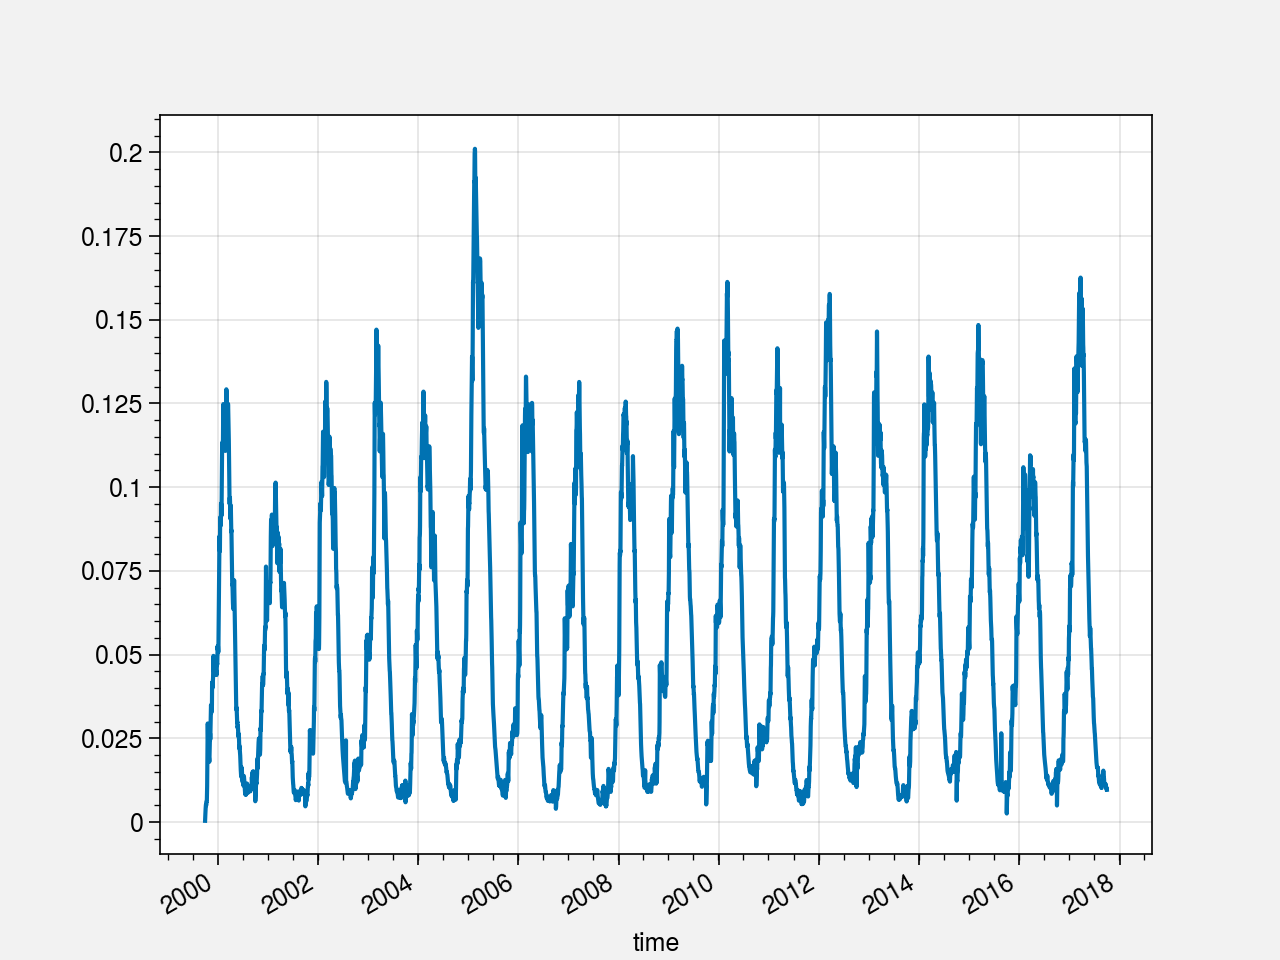

In [16]:
u.spatial_average(da).plot()

In [17]:
%%time
path='/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/WY1999_00/'
mask = xr.open_mfdataset(path+'HMA_SR_D_v01_*_agg_16_WY1999_00_MASK.nc', parallel=True).Non_seasonal_snow_mask
permanent_snow_count = mask.coarsen(Latitude=225, Longitude=225).sum().load()
permanent_snow_count = permanent_snow_count.rename({'Longitude': 'lon', 'Latitude': 'lat'}).transpose("lat", "lon")
permanent_snow_count['lat'] = np.round(permanent_snow_count.lat, 1) ; permanent_snow_count['lon'] = np.round(permanent_snow_count.lon, 1)
mask_psnow = (permanent_snow_count/(225*225)*100)

CPU times: user 12.2 s, sys: 499 ms, total: 12.7 s
Wall time: 21.9 s


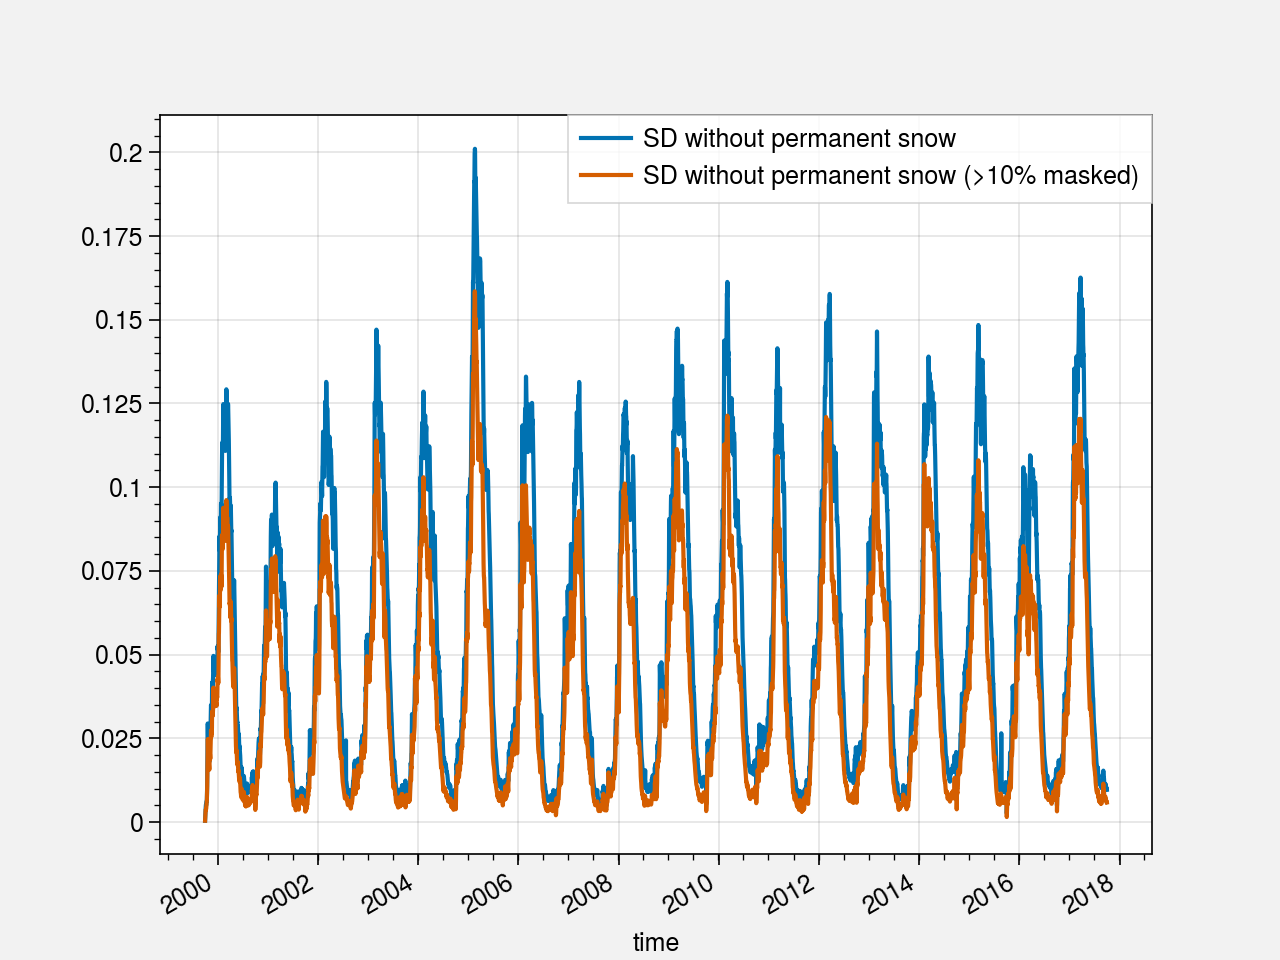

In [26]:
u.spatial_average(da).plot(label='SD without permanent snow')
u.spatial_average(da.where(mask_psnow<=10)).plot(label='SD without permanent snow (>10% masked)')
plt.legend()